In [1]:
# ─── Core --------------------------------------------------------------------
import torch
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torch.utils.data import DataLoader, TensorDataset

# ─── DeepSynergy package -----------------------------------------------------
from deepsynergy import (
    DeepSynergy,
    decoders,
    encoders
)
from deepsynergy.utils_training import (
    train_decoder,
    train_deepsynergy_model,
    relax_deepsynergy_model,
    evaluate_deepsynergy_entropy,
    ParameterScheduler,
)

# ─── Synthetic-data helper ---------------------------------------------------
from deepsynergy.utils_data import gaussian_triplet   # generates (X, Y) samples

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Gaussian Triplet — Synergy Estimation

We generate a triplet of jointly Gaussian variables  
$(Y, X_1, X_2)$ with a prescribed correlation matrix:

$$
\Sigma =
\begin{pmatrix}
1 & a & c \\
a & 1 & b \\
c & b & 1
\end{pmatrix}
$$

Our goal is to compare theoretical and DeepSynergy-based estimates of the following quantities:

- $H(Y \mid X_1, X_2)$
- $H(X_i \mid Y)$ for $i = 1, 2$
- $\displaystyle \max_Z H(Y \mid Z)$ under the Blackwell constraint

We then compute the synergy as:

$$
S = \max_Z H(Y \mid Z) \,-\, H(Y \mid X_1, X_2)
$$

All information values are measured in **bits**.

In [2]:
# ─── Correlation coefficients (Barrett et al., 2022) ──────
a, b, c = 0.5, 0.1, 0.9

# 3×3 correlation matrix
Σ = np.array([
    [1.0, a,  c],
    [a,  1.0, b],
    [c,   b, 1.0],
])

# --- Analytic conditional entropy H(Y | X1, X2) ----------------------
# From determinant identity for multivariate Gaussians
detΣ       = np.linalg.det(Σ)
var_cond   = detΣ / (1.0 - b**2)  # Conditional variance of Y given X1, X2
H_Y_given_X1X2 = 0.5 * np.log(2 * np.pi * np.e * var_cond) / np.log(2)

# --- Analytic conditional entropy H(Y | Xi) for i = 1, 2 -------------
H_Y_given_X1 = 0.5 * np.log(2 * np.pi * np.e * (1 - a**2)) / np.log(2)
H_Y_given_X2 = 0.5 * np.log(2 * np.pi * np.e * (1 - c**2)) / np.log(2)

# --- Mutual information I(Y; Xi) using closed-form for Gaussians -----
mi_biv_gauss = lambda r: -0.5 * np.log1p(-r**2) / np.log(2)

I_Y_X1   = mi_biv_gauss(a)
I_Y_X2   = mi_biv_gauss(c)
I_Y_X1X2 = 0.5 * np.log2((1 - b**2) / detΣ)

# --- Theoretical synergy (difference between total and maximal pairwise info)
synergy = I_Y_X1X2 - max(I_Y_X1, I_Y_X2)

print(f"Theoretical synergy: {synergy:.3f} bits")

Theoretical synergy: 1.617 bits


In [3]:
# 1 000 samples from the specified Gaussian joint distribution
X, Y = gaussian_triplet(
    a      = a,
    b      = b,
    c      = c,
    samples = 1_000,
)

X = X.to(device)      # shape (1000, 2)
Y = Y.to(device)      # shape (1000, 1)

print(f"Sample shapes  X: {X.shape},  Y: {Y.shape}")

Sample shapes  X: torch.Size([1000, 2]),  Y: torch.Size([1000, 1])


/home/nuzzi/Projects/DeepSynergy/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


### 1 · Decoder for $H(Y\mid X_1,X_2)$

100%|██████████| 1000/1000 [00:44<00:00, 22.26it/s, loss=[-0.7741521]]


H(Y|X₁,X₂)   theory : -0.768 bits
H(Y|X₁,X₂)   decoder: -0.774 bits


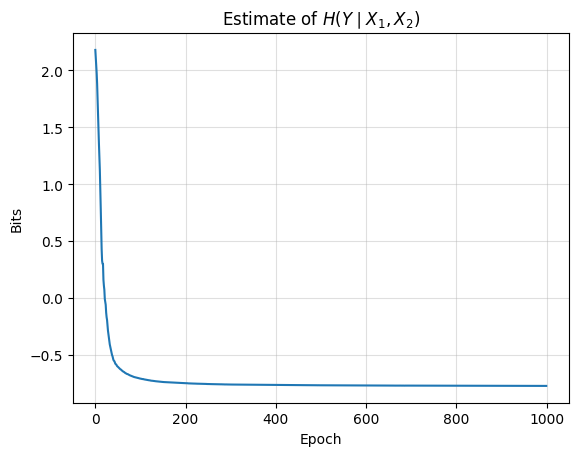

In [4]:
# Parameters
batch_size = 200
epochs      = 1_000
lr          = 1e-2

# DataLoader
dl_y_x = DataLoader(TensorDataset(X, Y), batch_size=batch_size)

# Decoder  q(y | x₁,x₂)
decoder_y_x = decoders.GaussianDecoder(
    nn.Sequential(
        nn.Linear(2, 4), nn.ReLU(),
        nn.Linear(4, 8), nn.ReLU(),
        nn.Linear(8, 4), nn.ReLU(),
    ),
    output_dim = 1,
).to(device)

optim = torch.optim.Adam(decoder_y_x.parameters(), lr=lr)

results_y_x = train_decoder(
    model         = decoder_y_x,
    dataloader    = dl_y_x,
    optimizer     = optim,
    show_progress = True,
    device        = device,
    epochs        = epochs,
)

plt.figure()
plt.plot(results_y_x["loss_history"], color="tab:blue")
plt.title("Estimate of $H(Y\\mid X_1,X_2)$")
plt.xlabel("Epoch"); plt.ylabel("Bits"); plt.grid(alpha=0.4)

print(f"H(Y|X₁,X₂)   theory : {H_Y_given_X1X2:.3f} bits")
print(f"H(Y|X₁,X₂)   decoder: {results_y_x['loss'][0]:.3f} bits")

### 2 · Decoder for $H(X_i\mid Y)$

100%|██████████| 500/500 [00:21<00:00, 22.74it/s, loss=[1.8166548  0.82240725]]


H(X₁|Y) theory : 1.840 bits ; decoder : 1.817
H(X₂|Y) theory : 0.849 bits ; decoder : 0.822


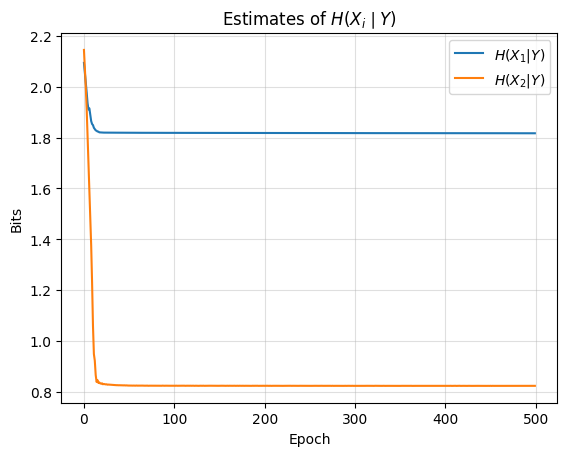

In [5]:
# Parameters
batch_size = 200
epochs      = 500
lr          = 1e-2

# DataLoader  (predictor = Y, target = X)
dl_x_y = DataLoader(TensorDataset(Y, X), batch_size=batch_size)

# Decoder  q(x₁,x₂ | y)
decoder_x_y = decoders.GaussianDecoder(
    nn.Sequential(
        nn.Linear(1, 4), nn.ReLU(),
        nn.Linear(4, 8), nn.ReLU(),
        nn.Linear(8, 4), nn.ReLU(),
    ),
    output_dim = 2,
).to(device)

optim = torch.optim.Adam(decoder_x_y.parameters(), lr=lr)

results_x_y = train_decoder(
    model         = decoder_x_y,
    dataloader    = dl_x_y,
    optimizer     = optim,
    show_progress = True,
    device        = device,
    epochs        = epochs,
)

plt.figure()
plt.plot(results_x_y["loss_history"][:, 0], label="$H(X_1|Y)$")
plt.plot(results_x_y["loss_history"][:, 1], label="$H(X_2|Y)$")
plt.title("Estimates of $H(X_i\\mid Y)$")
plt.xlabel("Epoch"); plt.ylabel("Bits"); plt.legend(); plt.grid(alpha=0.4)

print(f"H(X₁|Y) theory : {H_Y_given_X1:.3f} bits ; decoder : {results_x_y['loss'][0]:.3f}")
print(f"H(X₂|Y) theory : {H_Y_given_X2:.3f} bits ; decoder : {results_x_y['loss'][1]:.3f}")

### 3 · DeepSynergy training

100%|██████████| 2500/2500 [12:50<00:00,  3.25it/s, beta=100, loss_y=[0.883972], loss_x=[1.8416653  0.88597137]]   


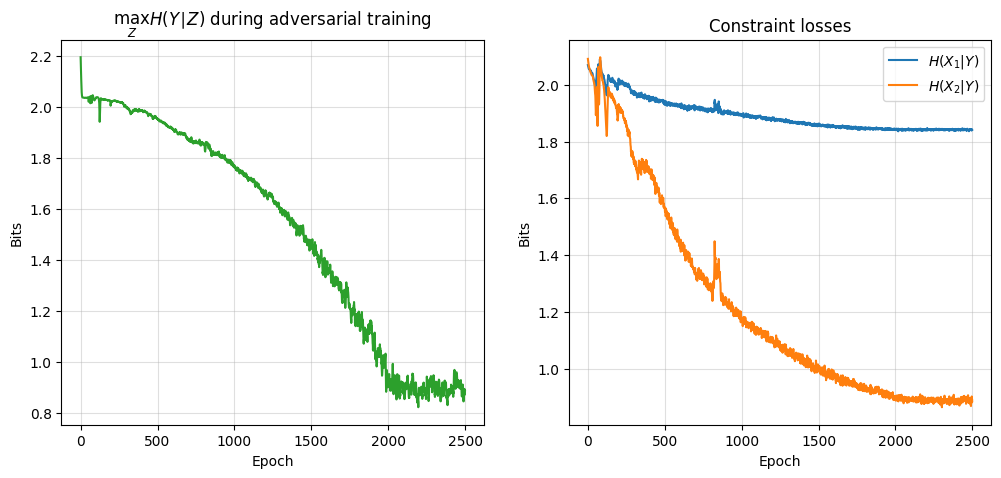

In [8]:
latent_dim = 2

encoder = encoders.GaussianEncoder(
    nn.Sequential(
        nn.Linear(1, 8), nn.ReLU(),
        nn.Linear(8, 16), nn.ReLU(),
    ),
    latent_dim=latent_dim,
    layers_post=nn.Sequential(
        nn.Linear(latent_dim, 8), nn.ReLU(),
        nn.Linear(8, latent_dim),
    )
)

disc_y = decoders.GaussianDecoder(
    nn.Sequential(
        nn.Linear(latent_dim, 4), nn.ReLU(),
        nn.Linear(4, 8), nn.ReLU(),
        nn.Linear(8, 4), nn.ReLU(),
    ),
    output_dim = 1,
)

gen_x = decoders.GaussianDecoder(
    nn.Sequential(
        nn.Linear(latent_dim, 4), nn.ReLU(),
        nn.Linear(4, 8), nn.ReLU(),
        nn.Linear(8, 4), nn.ReLU(),
    ),
    output_dim = 2,
)

model = DeepSynergy(
    q_z_given_y = encoder,
    q_y_given_z = disc_y,
    q_x_given_z = gen_x,
    num_z_samples = 100,
    optimizer   = (torch.optim.Adam, torch.optim.Adam),
    lr          = (1e-3, 1e-3),
).to(device)

beta_sched = ParameterScheduler(
    value_min = 1,
    value_max = 100,
    epochs_num = 2_000,
    method = "logarithm",
)

train_ds = train_deepsynergy_model(
    model           = model,
    dataloader      = dl_y_x,          # (X,Y) pairs
    beta            = beta_sched,
    alpha           = 5,
    n_critic        = 5,
    epochs          = 2_500,
    device          = device,
)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_ds["loss_y_history"], color="tab:green")
plt.title("$\\max_Z H(Y\\mid Z)$ during adversarial training")
plt.xlabel("Epoch"); plt.ylabel("Bits"); plt.grid(alpha=0.4)

plt.subplot(1, 2, 2)
plt.plot(train_ds["loss_x_history"][:, 0], label="$H(X_1|Y)$")
plt.plot(train_ds["loss_x_history"][:, 1], label="$H(X_2|Y)$")
plt.legend(); plt.title("Constraint losses")
plt.xlabel("Epoch"); plt.ylabel("Bits"); plt.grid(alpha=0.4)

### 4 · Discriminator-only relaxation


100%|██████████| 1000/1000 [01:07<00:00, 14.80it/s, loss_y=[0.8865835]]


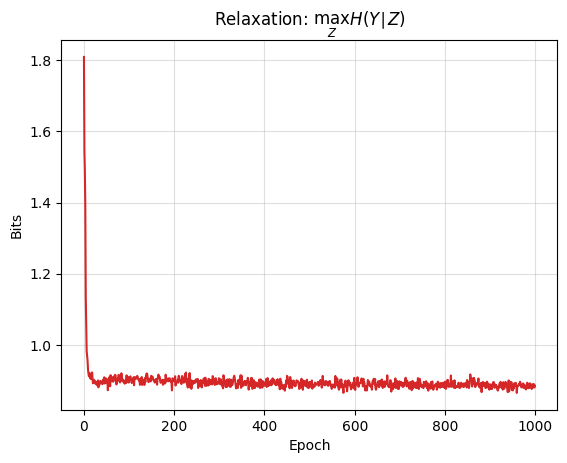

In [9]:
# fresh optimisers to remove momentum before relaxation
model.reset_optimizers(optimizer="Adam", lr=1e-2)

relax_ds = relax_deepsynergy_model(
    model         = model,
    dataloader    = dl_y_x,
    epochs        = 1000,
    device        = device,
)

plt.figure()
plt.plot(relax_ds["loss_y_history"], color="tab:red")
plt.title("Relaxation: $\\max_Z H(Y\\mid Z)$")
plt.xlabel("Epoch"); plt.ylabel("Bits"); plt.grid(alpha=0.4)

### 5 · Synergy

In [13]:
H_Y_given_Z_est = relax_ds["loss_y"][0]
synergy_est     = H_Y_given_Z_est - H_Y_given_X1X2

print(f"Synergy estimate : {synergy_est:.3f} bits")
print(f"Theoretical value: {synergy:.3f} bits")

Synergy estimate : 1.654 bits
Theoretical value: 1.617 bits
